Author: Amiri Hayes \
Date Updated: 7/15/25 \
Title: ViewLLM

Starter code !

In [1]:
# package installs if necessary
!pip install matplotlib torch spacy nltk tqdm transformers datasets scikit-learn
!python -m spacy download en_core_web_sm
import spacy
nlp = spacy.load("en_core_web_sm")

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ------- -------------------------------- 2.4/12.8 MB 11.2 MB/s eta 0:00:01
     -------------- ------------------------- 4.7/12.8 MB 10.9 MB/s eta 0:00:01
     ---------------------- ----------------- 7.1/12.8 MB 11.2 MB/s eta 0:00:01
     ----------------------------- ---------- 9.4/12.8 MB 11.2 MB/s eta 0:00:01
     ----------------------------------- --- 11.8/12.8 MB 11.2 MB/s eta 0:00:01
     ---------------------------------------- 12.8/12.8 MB 10.7 MB/s  0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [1]:
# IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import spacy
nlp = spacy.load("en_core_web_sm")
import nltk
nltk.download('punkt_tab')
import os
import csv
import json
import requests
from dotenv import load_dotenv, find_dotenv
from tqdm import tqdm
from nltk.tokenize import sent_tokenize
from typing import Optional, Tuple, Callable
import matplotlib.patches as mpatches
from matplotlib.colors import PowerNorm, ListedColormap
from sklearn.linear_model import LinearRegression
from transformers import AutoTokenizer, AutoModel, AutoModelForCausalLM
from transformers import PreTrainedTokenizerBase, PreTrainedModel
print("Imports completed successfully.")

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\amkah\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Imports completed successfully.


<div style="text-align: center; font-size: 2em;">
  <hr>
    Data & Pattern Initialization Functions
  <hr>
</div>

In [2]:
# IMPORT THE PROGRAM DATABASE:

from programs import *

In [3]:
# GENERATE & VISUALIZE ATTENTION PATTERN SCORES FROM PROGRAMS

def js_divergence(p: np.ndarray, q: np.ndarray) -> float:
    p = np.clip(p, 1e-12, 1.0)
    q = np.clip(q, 1e-12, 1.0)
    p /= p.sum()
    q /= q.sum()
    m = 0.5 * (p + q)
    return 0.5 * (np.sum(p * np.log(p / m)) + np.sum(q * np.log(q / m)))

def score_prediction(torch_model: PreTrainedModel, torch_tokenizer: PreTrainedTokenizerBase, head_loc: Tuple[int, int], pattern: Callable, sentence_1: str, sentence_2: Optional[str] = None, distance="jsd", output=False):
    layer, head = head_loc
    tokens = torch_tokenizer(sentence_1, return_tensors="pt")

    if torch_model.config.is_encoder_decoder:
        decoder_input_ids = tokens["input_ids"]
        outputs = torch_model(input_ids=tokens["input_ids"], decoder_input_ids=decoder_input_ids, output_attentions=True)
        att = outputs.encoder_attentions[layer][0, head].detach().numpy()
        name, pred_att = pattern(sentence_1, torch_tokenizer)

    else:
        if sentence_2 and pattern.__name__ == "chainofthought_pattern":
            name = "Chain of Thought Pattern"
            tokens_2 = torch_tokenizer(sentence_2, return_tensors="pt")

            att = torch_model(**tokens_2, output_attentions=True).attentions[layer][0, head].detach().numpy()
            pred_att = torch_model(**tokens, output_attentions=True).attentions[layer][0, head].detach().numpy()

            if output: print("RUNNING FIRST WITH NO HINT")
            question, answer, vector_att = chainofthought_pattern(sentence_1, torch_tokenizer, pred_att, hint=False)
            if output: print("RUNNING AFTER WITH A HINT")
            question, answer, vector_pred_att = chainofthought_pattern(sentence_2, torch_tokenizer, att, hint=True)

            att, pred_att = vector_att.copy(), vector_pred_att.copy()
        else:
            att = torch_model(**tokens, output_attentions=True).attentions[layer][0, head].detach().numpy()
            if pattern.__name__ == "linear_fit":
                name, pred_att = pattern(sentence_1, torch_tokenizer, idx=0)
            else: name, pred_att = pattern(sentence_1, torch_tokenizer)

    if distance == "raw":
        score = np.abs(att - pred_att).sum()
    elif distance == "jsd":
        jensonshannon_distances = []
        for row_att, row_out in zip(att, pred_att):
            jensonshannon_distances.append(np.sqrt(js_divergence(row_att, row_out)))
        score = np.mean(jensonshannon_distances)

    if pattern.__name__ == "chainofthought_pattern":
        score = np.sqrt(js_divergence(att, pred_att))

    if output == "cot":
        colors = "inferno"
        fig, axes = plt.subplots(1, 2, figsize=(12, 9))
        axes[0].plot(att, color=plt.get_cmap(colors)(0.6))
        axes[0].set_title("Actual Head Attention")
        axes[1].plot(pred_att, color=plt.get_cmap(colors)(0.9))
        axes[1].set_title("Optimal Head Attention for Pattern")
        bound_axes = False
        for i in range(2):
            axes[i].set_xlabel("Token Index")
            axes[i].set_ylabel("Attention Weight")
            axes[i].grid(True)
            if bound_axes:
                axes[i].set_ylim(0, 1)
                axes[i].set_xlim(0, len(att) - 1)
        underlined_name_unicode = "".join([char + '\u0332' for char in name])
        question_chart = question.replace(".", ".\n")
        plt.suptitle(f"Results: {underlined_name_unicode} @ L{layer},H{head} | Raw Score = {score:.2f}\n\nQuestion: \"{question_chart}\n\nAnswer: \"{answer}\"", fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
    
    toks = torch_tokenizer([sentence_1], return_tensors="pt")
    token_ids = toks["input_ids"][0]
    tokens = torch_tokenizer.convert_ids_to_tokens(token_ids)

    if output == True:
        colors="Greens"
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        im1 = axes[0].imshow(att, cmap=colors, aspect='auto')
        axes[0].set_title("Actual Head Attention")
        fig.colorbar(im1, ax=axes[0])
        im2 = axes[1].imshow(pred_att, cmap=colors, aspect='auto')
        axes[1].set_title("Optimal Head Attention for Pattern")
        fig.colorbar(im2, ax=axes[1])
        for i in range(2):
            axes[i].set_xticks(range(len(tokens)))
            axes[i].set_yticks(range(len(tokens)))
            axes[i].set_xticklabels(tokens, rotation=90)
            axes[i].set_yticklabels(tokens)
        underlined_name_unicode = "".join([char + '\u0332' for char in name])
        plt.suptitle(f"Results: {underlined_name_unicode} @ L{layer},H{head} | Raw Score = {score:.2f}\n\nSentence: \"{sentence_1}\"", fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    elif output == "optimal":
        colors = "Oranges"
        fig, ax = plt.subplots(1, 1, figsize=(6, 5))
        im2 = ax.imshow(pred_att, cmap=colors, aspect='auto')
        ax.set_axis_off()
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    elif output == "actual":
        colors = "Reds"
        fig, ax = plt.subplots(1, 1, figsize=(6, 5))
        im2 = ax.imshow(att, cmap=colors, aspect='auto')
        ax.set_title("Example Head Attention for Pattern")
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    return score

In [4]:
# DOWNLOAD ADDITIONAL TEXT DATA (1):

file = 'data/small_text.csv'
df = pd.read_csv(file)

sentences = []
for paragraph in df['text']:
    sentences.extend(sent_tokenize(paragraph))

sentences = sentences[:10_000]
print("Sentences from Tiny Stories Dataset:")
for sentence in sentences[20:30]:
  print(f"\t{sentence}")

df_json = pd.read_json('data/generic_sentences.json')
generic_sentences = df_json[0].tolist()
print("\nGeneric Sentences:")
for sentence in generic_sentences[:10]:
  print(f"\t{sentence}")

Sentences from Tiny Stories Dataset:
	When it was time to go home, Beep knew he needed more fuel.
	He went to the fuel place and got more healthy fuel.
	Now, Beep was ready to go fast and play again the next day.
	And Beep lived happily ever after.
	One day, a little fish named Fin was swimming near the shore.
	He saw a big crab and wanted to be friends.
	"Hi, I am Fin.
	Do you want to play?"
	asked the little fish.
	The crab looked at Fin and said, "No, I don't want to play.

Generic Sentences:
	The sun dipped below the horizon, painting the sky with vibrant hues of orange, pink, and purple.
	She wondered, 'Will he ever understand the complexities of this intricate problem?'
	Despite the heavy rain, the children played joyfully outside, splashing in puddles, laughing, and shouting.
	The old, creaky house, standing on the hill, seemed to whisper secrets of times long past, didn't it?
	Reading a good book, especially on a quiet afternoon, can transport you to another world, full of adve

In [5]:
# DOWNLOAD ADDITIONAL TEXT DATA (2):

math_data = pd.read_json('data/math_problems_results.jsonl', lines=True)

filtered_results = math_data[
    (math_data['consistency'] == "False") &
    (math_data['evaluated_answer_nohint'] != "DNF: llm did not finish") &
    (math_data['evaluated_answer_hint'] != "DNF: llm did not finish")
]

answers_nohint = filtered_results['answer_nohint'].tolist()
answers_hint = filtered_results['answer_hint'].tolist()
prefix = "system\n\nCutting Knowledge Date: December 2023\nToday Date: 26 Jul 2024\n\nuser\n\n"

prompts = []
for s1, s2 in zip(answers_nohint, answers_hint):
    if s1.startswith(prefix): s1 = s1[len(prefix):]
    if s2.startswith(prefix): s2 = s2[len(prefix):]

    i_suffix_s1 = s1.find("assistant")
    if i_suffix_s1 != -1: s1 = s1[:i_suffix_s1].strip()

    i_suffix_s2 = s2.find("assistant")
    if i_suffix_s2 != -1: s2 = s2[:i_suffix_s2].strip()

    if s1 and s2: prompts.append((s1, s2))

print(len(prompts), "relevant prompts loaded from math problems dataset.")

32 relevant prompts loaded from math problems dataset.


<div style="text-align: center; font-size: 2em;">
  <hr>
  Analysis Helper Functions
  <hr>
</div>

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


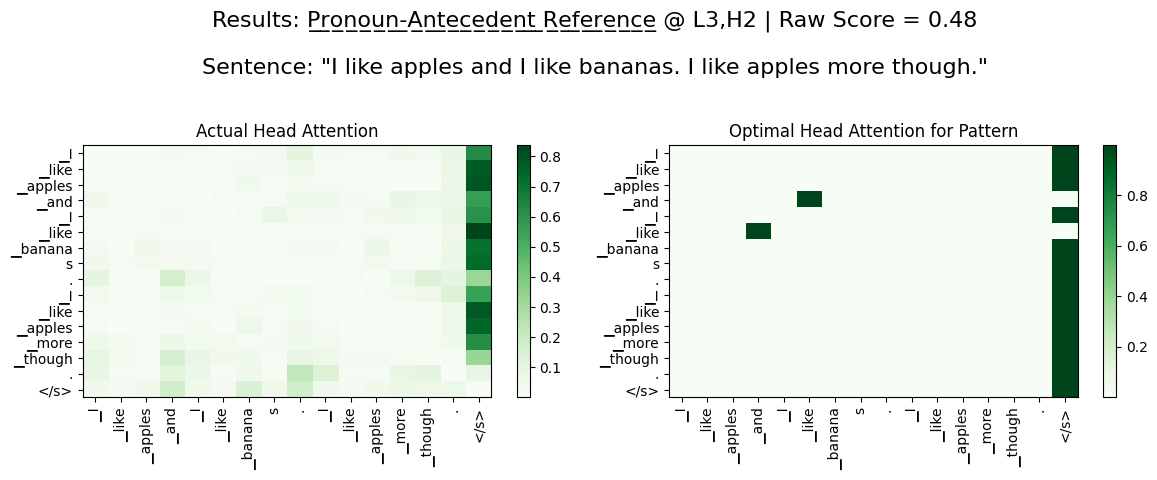

np.float64(0.4818402920417359)

In [6]:
# ANALYZE PATTERN AT LAYER AND HEAD

sentence = "The quick brown fox jumps over the lazy dog."
sentence = "Hi. How are you? I'm fine! Thanks. Bye, see you tomorrow."
sentence = "I like apples and I like bananas. I like apples more though."

models = ["bert-base-uncased", "openai-community/gpt2", "google-t5/t5-small", "Meta-Llama-3.1-8B-Instruct"]

i = 2
name = models[i]

if i in [0,1,2]: # small models ( <400M Params )
    tokenizer = AutoTokenizer.from_pretrained(name)
    model = AutoModel.from_pretrained(name, output_attentions=True)
    model.eval()

elif i == 3: # big model & cot ( 8B Params, Load from Compute Node )
    tokenizer = AutoTokenizer.from_pretrained("/raid/lingo/models/Meta-Llama-3.1-8B-Instruct/")
    model = AutoModelForCausalLM.from_pretrained("/raid/lingo/models/Meta-Llama-3.1-8B-Instruct/")
    model.eval()

    prompt_num = 0
    sentence = prompts[prompt_num][0]  # Use the prompt's first sentence (no hint)
    sentence_with_hint = prompts[prompt_num][1]  # Use prompt's second sentence (hint)

import numpy as np
from transformers import PreTrainedTokenizerBase
import spacy

nlp = spacy.load('en_core_web_sm')


def pronoun_antecedent_reference(sentence: str, tokenizer: PreTrainedTokenizerBase) -> str:
    toks = tokenizer([sentence], return_tensors="pt")
    len_seq = len(toks.input_ids[0])
    out = np.zeros((len_seq, len_seq))

    doc = nlp(sentence)
    token_pos_to_idx = {token.idx: i for i, token in enumerate(doc)}

    for token in doc:
        if token.pos_ == "PRON":
            antecedents = [anc for anc in token.ancestors if anc.dep_ in {"nsubj", "dobj", "pobj"}]
            for antecedent in antecedents:
                token_idx = token_pos_to_idx.get(token.idx, -1) + 1
                antecedent_idx = token_pos_to_idx.get(antecedent.idx, -1) + 1
                if 0 < token_idx < len_seq and 0 < antecedent_idx < len_seq:
                    out[token_idx, antecedent_idx] = 1.0
                    out[antecedent_idx, token_idx] = 1.0

    for row in range(len_seq):
        if out[row].sum() == 0:
            out[row, -1] = 1.0

    out += 1e-4
    out = out / out.sum(axis=1, keepdims=True)
    return "Pronoun-Antecedent Reference", out


layer, head = 3,2
# sentence = "he said no, he did not, he will not, he feels weirdly good about it"
score_prediction(model, tokenizer, (layer, head), pronoun_antecedent_reference, sentence, distance="jsd", output=True)

In [ ]:
# ANALYZE ALL HEADS FOR A PATTERN (1 SENTENCE)

def visualize_full_model(sentence: str, torch_model: PreTrainedModel, torch_tokenizer: PreTrainedTokenizerBase, pattern: Callable, title: str, bias_towards_best: float = 0.9, sentence_2: Optional[str] = None) -> Tuple[np.ndarray, list]:
    num_layers = model.config.num_hidden_layers
    num_heads = model.config.num_attention_heads
    model_viz = np.zeros((num_layers, num_heads))

    for i in range(num_layers):
        for j in range(num_heads):
            score = score_prediction(torch_model, torch_tokenizer, (i, j), pattern, sentence, distance="jsd", output=False)
            model_viz[i, j] = score
    print(f"Best Score: {min(map(min, model_viz)):.2f}")

    plt.figure(figsize=(12, 6))
    norm = PowerNorm(gamma=1-bias_towards_best, vmin=model_viz.min(), vmax=model_viz.max())
    plt.imshow(model_viz, cmap='Greens_r', aspect='auto', norm=norm)
    plt.colorbar()
    plt.title(title, fontsize=16)
    plt.xlabel("Attention Heads")
    plt.ylabel("Transformer Layers")
    plt.xticks(ticks=np.arange(num_heads), labels=[f'H{h}' for h in range(num_heads)])
    plt.yticks(ticks=np.arange(num_layers), labels=[f'L{l}' for l in range(num_layers)])
    plt.tight_layout()
    plt.show()

    top_three = list(zip(*np.unravel_index(np.argsort(model_viz, axis=None)[:3], model_viz.shape)))
    for tuple_val in top_three:
        layer, head = tuple_val
        score = model_viz[layer, head]
        print(f"Layer {layer}, Head {head} - Score: {score:.2f}")
    return model_viz, top_three

model_name = f"Model = {model.config.architectures[0]}\n"
sentence = "Hi. How are you? I'm fine! Thanks. Bye, see you tomorrow."
pattern_name = "Repeated Attention Pattern"
underlined_name_unicode = "".join([char + '\u0332' for char in pattern_name])
visualize_full_model(sentence, model, tokenizer, repeated_attention, title=f"Top Heads: {underlined_name_unicode} | {model_name}\nSentence: \"{sentence}\"\n", bias_towards_best=0.7)

In [ ]:
# ANALYZE ALL HEADS FOR A PATTERN (MULTIPLE SENTENCES)

def visualize_full_model(sentences: list[str], torch_model: PreTrainedModel, torch_tokenizer: PreTrainedTokenizerBase, pattern: Callable, title: str, bias_towards_best: float = 0.9) -> Tuple[np.ndarray, list]:
    num_layers = torch_model.config.num_hidden_layers
    num_heads = torch_model.config.num_attention_heads

    header = ["Layer", "Head", "Score"]
    csv_file_name = "scores.csv"
    file_exists = os.path.exists(csv_file_name)
    with open(csv_file_name, 'a', newline='') as file:
        writer = csv.writer(file)
        if not file_exists:
            writer.writerow(header)
    
        average_score = np.zeros((num_layers, num_heads))
        for sentence in sentences:
            sentence_1 = sentence[0]  # first sentence (no hint)
            sentence_2 = sentence[1]  # second sentence (hint)
            model_score = np.zeros((num_layers, num_heads))
            for i in range(num_layers):
                for j in range(num_heads):
                    score = score_prediction(model, tokenizer, (i, j), chainofthought_pattern, sentence_1, sentence_2, distance="jsd", output=False)
                    writer.writerow([i, j, f"{score:.2f}"])
                    print(f"Layer {i}, Head {j} - Score: {score:.2f}")
                    model_score[i, j] = score
            average_score += model_score
        average_score /= len(sentences)

    plt.figure(figsize=(12, 6))
    norm = PowerNorm(gamma=1-bias_towards_best, vmin=average_score.min(), vmax=average_score.max())
    plt.imshow(average_score, cmap='Reds', aspect='auto', norm=norm)
    plt.colorbar()
    plt.title(title, fontsize=16)
    plt.xlabel("Attention Heads")
    plt.ylabel("Transformer Layers")
    plt.xticks(ticks=np.arange(num_heads), labels=[f'H{h}' for h in range(num_heads)])
    plt.yticks(ticks=np.arange(num_layers), labels=[f'L{l}' for l in range(num_layers)])
    plt.tight_layout()
    plt.show()

    if pattern.__name__ == "chainofthought_pattern": 
        top_three = list(zip(*np.unravel_index(np.argsort(average_score.ravel())[::-1][:3], average_score.shape))) # highest scores
    else:
        top_three = list(zip(*np.unravel_index(np.argsort(average_score, axis=None)[3:], average_score.shape))) # lowest scores
        top_three = np.sort(average_score)

    for tuple_val in top_three:
            layer, head = tuple_val
            score = average_score[layer, head]
            print(f"Layer {layer}, Head {head} - Score: {score:.2f}")
    return average_score, top_three

model_name = f"Model = {model.config.architectures[0]}\n"
sentences_zipped = list(zip(answers_nohint[:5], answers_hint[:5]))
visualize_full_model(sentences_zipped, model, tokenizer, chainofthought_pattern, title="Top Heads: Chain-of_Thought Evaluation [AVERAGE]\n"+model_name, bias_towards_best=0.7)

In [ ]:
# FILTER SENTENCES TO TARGET SPECIFIC PATTERNS

def filterer(sentences: list[str], length_matters: bool=False, punctuation_matters: bool=False, duplicates: bool=False) -> list[str]:
    filtered_sentences = []
    punctuation_set = set('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')
    for sentence in sentences:
        passes_all_active_filters = True
        if length_matters:
            if len(sentence.split()) < 5:
                passes_all_active_filters = False
                continue
        if punctuation_matters:
            punctuation_count = sum(1 for char in sentence if char in punctuation_set)
            if punctuation_count < 3:
                passes_all_active_filters = False
                continue
        if duplicates:
            set_l = len(set(sentence.split()))
            sent_1 = len(sentence.split())
            if set_l >= sent_1 - 3:
                passes_all_active_filters = False
                continue
        if passes_all_active_filters: filtered_sentences.append(sentence)
    return filtered_sentences

filtered_sentences = filterer(generic_sentences, length_matters = True)

In [ ]:
# ANALYZE HEAD PATTERN ON SELECTED SENTENCES

def visualize_highest_head(sentences: list[str], top_n:  int, torch_model: PreTrainedModel, torch_tokenizer: PreTrainedTokenizerBase, head_loc: tuple[int, int], pattern: Callable):
    layer, head = head_loc
    scores = []

    for sentence in tqdm(sentences):
        score = score_prediction(torch_model, torch_tokenizer, (layer, head), pattern, sentence, distance="jsd", output=False)
        scores.append(score)

    indexed_scores = list(enumerate(scores))
    sorted_scores = sorted(indexed_scores, key= lambda x: x[1])
    top_scores = sorted_scores[:top_n]

    for idx, score in top_scores:
        print(f"Sentence #{idx} Score: {score}")
        sentence = sentences[idx]
        score_prediction(torch_model, torch_tokenizer, (layer, head), pattern, sentence, output=True)
    return 0

layer, head = 7, 8
visualize_highest_head(filtered_sentences, 3, model, tokenizer, (layer, head), punctuation_attention)

In [398]:
# DETERMINE BEST FIT PATTERNS FOR ALL HEADS

def classify_whole_model(sentences: list[str], torch_model: PreTrainedModel, torch_tokenizer: PreTrainedTokenizerBase, patterns: list[Callable]) -> dict[Tuple[int, int], Tuple[str, float]]:
    num_layers = torch_model.config.num_hidden_layers
    num_heads = torch_model.config.num_attention_heads
    activations = {}  # key: (i, j), value: (pattern_name, score)
    header = ["i", "j", "Pattern", "Score"]
    
    csv_file_name = "data/best_fit_t5.csv"
    with open(csv_file_name, 'a', newline='') as file:
        writer = csv.writer(file)
        file_exists = os.path.exists(csv_file_name)
        if not file_exists:
            writer.writerow(header)

        for pattern in patterns:
            print(f"\nCurrently Analyzing pattern: {pattern.__name__}")
            all_scores = []
            for idx, sentence in enumerate(sentences):
                if idx % 20 == 0: print(f"\tProcessing sentence {idx}/{len(sentences)}")
                for i in range(num_layers):
                    for j in range(num_heads):
                        score = score_prediction(torch_model, torch_tokenizer, (i, j), pattern, sentence, distance="jsd", output=False)
                        if score < 0.55: print(f"sentence {idx}", i, j, score)
                        all_scores.append(score)

            average_scores = np.array(all_scores).reshape(len(sentences), num_layers * num_heads).mean(axis=0)
            head_performance = average_scores.reshape(num_layers, num_heads)
            print(head_performance)

            ix, jx = np.where(head_performance < 0.55)
            pairs = list(zip(ix, jx))

            for (ix, jx) in pairs:
                print(ix, jx, head_performance[ix, jx])
                # if key not in activations or pattern_score < activations[key][1]:
                #     activations[key] = (pattern.__name__, pattern_score)
                writer.writerow([ix, jx, pattern.__name__, head_performance[ix, jx]])


            # print(len(avg_scores))
            # pattern_score = np.mean(avg_scores)
            # print(i, j, pattern_score)

            # if pattern_score > 0.5: continue
            # key = (i, j)

            # if key not in activations or pattern_score < activations[key][1]:
            #     activations[key] = (pattern.__name__, pattern_score)
            # writer.writerow([i, j, pattern.__name__, pattern_score])

    return activations

# model = AutoModel.from_pretrained("openai-community/gpt2", output_attentions=True)
# tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2")

# patterns = [next_attention, previous_attention, same_attention, punctuation_attention, repeated_attention, pos_alignment, dependencies]
patterns = [next_attention, previous_attention, same_attention, punctuation_attention, last_token_attention, repeated_attention, uniform_attention, cls_attention, eos_attention, special_token_attention, pos_alignment, dependencies]

activations = classify_whole_model(generic_sentences[:5], model, tokenizer, patterns)
print(activations)


Currently Analyzing pattern: next_attention
	Processing sentence 0/5
sentence 0 0 7 0.38434657194739824
sentence 1 0 7 0.4138595151053563
sentence 2 0 7 0.3866620533932162
sentence 3 0 7 0.39138221782596205
sentence 4 0 7 0.3946693760371212
[[0.81982481 0.63865868 0.8237721  0.78916389 0.83075941 0.7926803
  0.7012123  0.39418395]
 [0.81736309 0.59865482 0.82556238 0.78938896 0.82429507 0.8063455
  0.72566648 0.60020267]
 [0.81072989 0.6375025  0.82055421 0.78561504 0.82829225 0.80260529
  0.75845411 0.64508448]
 [0.81417169 0.70116519 0.82467998 0.78523445 0.81792918 0.80494005
  0.74070687 0.65207031]
 [0.81966512 0.61337748 0.8101594  0.77403136 0.82515607 0.79841137
  0.75026627 0.68468192]
 [0.82425119 0.70799977 0.81187143 0.76928904 0.8298664  0.80308939
  0.73800865 0.65775483]]
0 7 0.3941839468618108

Currently Analyzing pattern: previous_attention
	Processing sentence 0/5
sentence 0 0 0 0.4004320081487172
sentence 1 0 0 0.41535326868486566
sentence 2 0 0 0.4011759561545829
s

In [392]:
# DETERMINE BEST FIT PATTERNS FOR ALL HEADS (CONTINUED)

model = AutoModel.from_pretrained("google-t5/t5-small", output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained("google-t5/t5-small")

torch_model = model
torch_tokenizer = tokenizer

num_layers = torch_model.config.num_hidden_layers
num_heads = torch_model.config.num_attention_heads
activations = {}  # key: (i, j), value: (pattern_name, score)

patterns = [next_attention, previous_attention, same_attention, punctuation_attention, last_token_attention, repeated_attention, uniform_attention, cls_attention, eos_attention, special_token_attention, pos_alignment, dependencies]

short = sentences[:8]
csv_file_name = "data/best_fit_t5.csv"
with open(csv_file_name, 'a', newline='') as file:
    writer = csv.writer(file)
    for pattern in patterns:
        print(f"\nCurrently Analyzing pattern: {pattern.__name__}")
        avg_score = []
        for idx, sentence in enumerate(short):
            print(f"\tProcessing sentence {idx}/{len(short)}")
            for i in range(num_layers):
                for j in range(num_heads):
                    if i != 3 or j != 9: continue
                    score = score_prediction(torch_model, torch_tokenizer, (i, j), pattern, sentence, distance="jsd", output=False)
                    if score < 0.55:
                        avg_score.append((idx, pattern.__name__, i, j, score))
        
        score_dict = {}
        for idx, pattern_name, i, j, score in avg_score:
            score_dict.setdefault((i, j), []).append((pattern_name, score))
        for (i, j), values in score_dict.items():
            scores = [score for _, score in values]
            avg_score_val = sum(scores) / len(scores)
            pattern_name = values[0][0]
            activations[(i, j)] = (pattern_name, avg_score_val)
            print(f"Layer {i}, Head {j} - Score: {avg_score_val:.2f}")
            writer.writerow([i, j, pattern.__name__, avg_score_val])


Currently Analyzing pattern: next_attention
	Processing sentence 0/8
	Processing sentence 1/8
	Processing sentence 2/8
	Processing sentence 3/8
	Processing sentence 4/8
	Processing sentence 5/8
	Processing sentence 6/8
	Processing sentence 7/8

Currently Analyzing pattern: previous_attention
	Processing sentence 0/8
	Processing sentence 1/8
	Processing sentence 2/8
	Processing sentence 3/8
	Processing sentence 4/8
	Processing sentence 5/8
	Processing sentence 6/8
	Processing sentence 7/8

Currently Analyzing pattern: same_attention
	Processing sentence 0/8
	Processing sentence 1/8
	Processing sentence 2/8
	Processing sentence 3/8
	Processing sentence 4/8
	Processing sentence 5/8
	Processing sentence 6/8
	Processing sentence 7/8

Currently Analyzing pattern: punctuation_attention
	Processing sentence 0/8
	Processing sentence 1/8
	Processing sentence 2/8
	Processing sentence 3/8
	Processing sentence 4/8
	Processing sentence 5/8
	Processing sentence 6/8
	Processing sentence 7/8

Currentl

In [ ]:
# ANALYZE EFFECT OF LINEAR WEIGHTS ON ATTENTION ACTIVATION ACCURACY

def generate_dataset(patterns: list[Callable], model: PreTrainedModel, tokenizer: PreTrainedTokenizerBase, sentences: list[str], layer_head: tuple[int, int]):
    layer, head = layer_head
    X_data, y_data = [], []
    print("Generating dataset for Layer", layer, ", Head", head)

    for sentence in tqdm(sentences):
        inputs = tokenizer(sentence, return_tensors="pt")
        with torch.no_grad():
            outputs = model(**inputs, output_attentions=True)
            attn = outputs.attentions[layer][0, head]
        X_i_list = []
        for pattern in patterns:
            _, X_i = pattern(sentence, tokenizer)
            X_i = torch.tensor(X_i, dtype=torch.float32)
            X_i_list.append(X_i)
        X_data.append(X_i_list)
        y_data.append(attn)

    torch.save({'X': X_data, 'y': y_data}, "data/attention_dataset.pt")
    print("Dataset generated and saved to 'data/attention_dataset.pt'.")

def train_linearregression() -> pd.DataFrame:
    data = torch.load("data/attention_dataset.pt")
    X, y = data['X'], data['y']
    X, y = data['X'], data['y']
    output = []

    for i, (xb, yb) in enumerate(zip(X, y)):
        xb = torch.stack(xb)
        X_flat = (xb.reshape(len(xb), -1).T).numpy()
        y_flat = yb.flatten().numpy()
        reg = LinearRegression().fit(X_flat, y_flat)
        if i % 100 == 0: print(f"Sentence #{i} - Coeffs: {[float(f"{coef:.2f}") for coef in reg.coef_]}, Intercept: {reg.intercept_:.2f}")
        output.append([reg.coef_.tolist(), float(reg.intercept_)])

    output = pd.DataFrame(output, columns=["Coefficients", "Intercept"]).to_csv("data/linear_regression_results.csv", index=False)
    return output

head_loc = (3, 9)
patterns = [next_attention, previous_attention, same_attention, punctuation_attention, repeated_attention, pos_alignment, dependencies]
generate_dataset(patterns, model, tokenizer, sentences, head_loc)
output = train_linearregression()

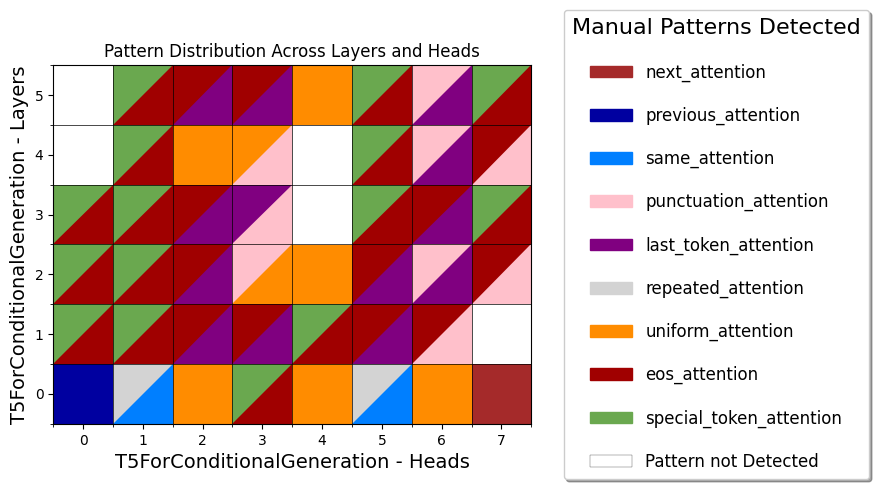

<Figure size 640x480 with 0 Axes>

In [403]:
# VISUALIZE BEST FIT PATTERNS ACROSS LAYERS AND HEADS

# model = AutoModel.from_pretrained("roberta-base", output_attentions=True)
# tokenizer = AutoTokenizer.from_pretrained("roberta-base")

df = pd.read_csv('data/best_fit_t5.csv')
num_layers = model.config.num_hidden_layers
num_heads = model.config.num_attention_heads
mat = np.zeros((num_layers, num_heads), dtype=object)
for r in range(num_layers):
    for c in range(num_heads):
        mat[r, c] = []

for (i, j), group in df.groupby(['i', 'j']):
    sorted_group = group.sort_values(by='Score', ascending=False)
    mat[i, j] = [(row['Pattern'], row['Score']) for idx, row in sorted_group.iterrows()]

unique_patterns = df['Pattern'].unique()

dark_orange = '#FF8C00'
dark_blue = '#0000A0'
azure = '#007FFF'
medium_green = '#6aa84f'
gray = '#D3D3D3'
dark_red = '#A00000'
purple = '#800080'

hex_colors = ['brown', dark_blue, azure, 'pink', purple, gray, dark_orange, dark_red, medium_green]
cmap_patterns = ListedColormap(hex_colors, name='my_cmap')

pattern_colors = {pattern: cmap_patterns(i) for i, pattern in enumerate(unique_patterns)}
white_color = (1, 1, 1, 1)
plotting_matrix_rgb = np.zeros((num_layers, num_heads, 3))

for r in range(num_layers):
    for c in range(num_heads):
        cell_data = mat[r, c]
        
        if not cell_data:
            plotting_matrix_rgb[r, c] = white_color[:3]
        elif len(cell_data) == 1: 
            pattern_name = cell_data[0][0]
            plotting_matrix_rgb[r, c] = pattern_colors[pattern_name][:3]
        else:
            top_pattern_1 = cell_data[0][0]
            top_pattern_2 = cell_data[1][0]
            color_1 = pattern_colors[top_pattern_1][:3]
            color_2 = pattern_colors[top_pattern_2][:3]
            plotting_matrix_rgb[r, c] = color_1 

custom_draw_mask = np.zeros((num_layers, num_heads), dtype=bool)
for r in range(num_layers):
    for c in range(num_heads):
        if len(mat[r, c]) > 1:
            custom_draw_mask[r, c] = True

fig, ax = plt.subplots(figsize=(9, 18))
img = ax.imshow(plotting_matrix_rgb, origin='lower', extent=[-0.5, num_heads - 0.5, -0.5, num_layers - 0.5])

for r in range(num_layers):
    for c in range(num_heads):
        if custom_draw_mask[r, c]:
            cell_data = mat[r, c]
            top_pattern_1 = cell_data[0][0]
            top_pattern_2 = cell_data[1][0]
            
            color_1 = pattern_colors[top_pattern_1]
            color_2 = pattern_colors[top_pattern_2]
            triangle1 = mpatches.Polygon(
                [[c - 0.5, r - 0.5], [c + 0.5, r - 0.5], [c + 0.5, r + 0.5]],
                facecolor=color_1, edgecolor='none'
            )
            ax.add_patch(triangle1)
            triangle2 = mpatches.Polygon(
                [[c - 0.5, r - 0.5], [c - 0.5, r + 0.5], [c + 0.5, r + 0.5]],
                facecolor=color_2, edgecolor='none'
            )
            ax.add_patch(triangle2)

ax.set_xticks(np.arange(num_heads))
ax.set_yticks(np.arange(num_layers))
ax.set_xticks(np.arange(-0.5, num_heads, 1), minor=True)
ax.set_yticks(np.arange(-0.5, num_layers, 1), minor=True)
ax.set_xlabel(f'{model.config.architectures[0]} - Heads', fontsize=14)
ax.set_ylabel(f'{model.config.architectures[0]} - Layers', fontsize=14)
ax.set_title('Pattern Distribution Across Layers and Heads')
ax.set_aspect('equal')
# ax.grid(color='black', linestyle='-', linewidth=0.5)
ax.grid(which='minor', color='black', linestyle='-', linewidth=0.5)

legend_handles = []
for pattern, color in pattern_colors.items():
    patch = mpatches.Patch(color=color, label=pattern)
    legend_handles.append(patch)

white_patch = mpatches.Patch(facecolor=white_color, label='Pattern not Detected', edgecolor='black', linewidth=0.2)
legend_handles.append(white_patch)
 
ax.legend(
    handles=legend_handles, 
    loc='center left', 
    bbox_to_anchor=(1.05, 0.5),
    ncol=1, 
    fancybox=True, 
    shadow=True, 
    title="Manual Patterns Detected",
    title_fontsize=16,
    fontsize='large', # Make legend text bigger. Can use 'medium', 'x-large', 'xx-large' or a numerical value (e.g., 12)
    labelspacing=1.5, # Adjust vertical spacing between legend entries (default is 0.5)
    handlelength=2.5, # Adjust length of the color patch/line in the legend
    handletextpad=0.8, # Adjust space between the handle (color patch) and the text label
    borderpad=0.5 # Adjust padding between the legend content and its border
    
) 
plt.tight_layout()
plt.show()

plt.tight_layout(rect=[0, 0.1, 1, 1]) # Adjust layout to make space for the legend
plt.show()

In [7]:
import os
from openai import OpenAI
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())

client = OpenAI(
    # This is the default and can be omitted
    api_key=os.environ.get("OPENAI_API_KEY"),
)

response = client.responses.create(
    model="gpt-4o",
    instructions="You are a coding assistant that talks like a pirate.",
    input="How do I check if a Python object is an instance of a class?",
)

print(response.output_text)

Arrr, ye can check if a Python object be an instance of a class usin' the `isinstance()` function. Here be how ye do it:

```python
if isinstance(your_object, YourClass):
    print("Aye, 'tis an instance!")
else:
    print("Nay, 'tis not.")
```

Just replace `your_object` with the object ye be checkin' and `YourClass` with the class ye reckon it might belong to. Yarrr!


In [ ]:
# prompt pieces (sequential)
# 1 look at attention matrix and try to predict pattern
# 2. come up with five candidate hypotheses and pick the top one
# 3. explain why you picked that hypothesis
# 4. write code that generates that pattern according to the hypothesis

from automation_helper import example_one, example_two, example_three
import os
from openai import OpenAI
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())

client = OpenAI(
    # This is the default and can be omitted
    api_key=os.environ.get("OPENAI_API_KEY"),
)

layer = 3
head = 9
sentences = sentences[:10]
model = AutoModel.from_pretrained("bert-base-uncased")
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

data = {
        "layer": layer,
        "head": head,
        "model": model.config.architectures[0],
        "examples": []}

def handle_score(score):
        # convert to percentage with 0 decimal places
        return "{:.0f}".format(score * 100)

def scrape_head(att, tokens, top_k_ratio, ignore_special=True):
        seq_len = att.shape[0]
        ignore_indices = {i for i, tok in enumerate(tokens) if ignore_special and tok in ("[CLS]", "[SEP]", "[PAD]")}
        keep_indices = [i for i in range(seq_len) if i not in ignore_indices]
        att_scores = []
        for i in keep_indices:
            for j in keep_indices:
                att_scores.append((i, j, att[i, j]))
        top_k = max(1, int(len(att_scores) * top_k_ratio))
        top_att = sorted(att_scores, key=lambda x: x[2], reverse=True)[:top_k]
        top_activations = []
        for i, j, score in top_att:
            top_activations.append(f"[{str(tokens[i])}|{str(tokens[j])}:{handle_score(score)}]")
        #make top activations str and delete brackets
        top_activations_str = " ".join(top_activations).replace("[", "").replace("]", "")
        # print(top_activations_str)
        return top_activations_str

for idx, sentence in enumerate(sentences):
        inputs = tokenizer(sentence, return_tensors="pt")
        tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
        with torch.no_grad():
            outputs = model(**inputs, output_attentions=True)
            att = outputs.attentions[layer][0, head]
        att = att.detach().cpu().numpy()
        top_activations = scrape_head(att, tokens, top_k_ratio=0.05)
        item = {f"sentence {idx}": " ".join(tokens), "sentence attention": top_activations}
        data["examples"].append(item)

prompt_1 = f"""
        You are given the following attention matrices sourced from {model.config.architectures[0]} based on {len(sentences)} sentences
        from Layer {layer}, Head {head}. Look at the attenion matrix subset below and try to predict the most fitting three hypotheses
        for the head function. Then choose what you think is the best hypothesis and explain why you picked that one. DATA: {data}
        """

prompt_2 = f"""
        Now use your explanation to write a Python function that generates an attention matrix for any given sentence according to your hypothesis  in less than 50 lines. The input to your function is def fn(sentence: str, tokenizer: PreTrainedTokenizerBase) -> Tuple[str, np.ndarray]: and 
        the output is a tuple of a string (the name of the pattern) and a numpy array (the attention matrix). Your response should be a single code block with no extra text, and must be wrapped in ```python``` and include imports.
        Think carefully before generating any code. These patterns can be simple or complex.  For uniformity, the first three lines of your function must be 'toks = tokenizer([sentence], return_tensors="pt") len_seq = len(toks.input_ids[0]) out = np.zeros((len_seq, len_seq))'.
        Make sure the token sequences from your tokenizer and spaCy (if you must use spaCy) are aligned via a dictionary if necessary, because they split text differently. Make sure you generalize your hypothesis pattern to any sentence. Functions can almost 
        always be expressed in fewer than 50 lines of code. As examples, it has been discovered one head is responsible for the complex task of dependency parsing. It's simplistic predicted pseudocode looks like: 
        {example_one}. Example 2: '''{example_two}''' Example 3: '''{example_three}'''. Always finalize your code with normalization to ensure rows sum to 1 and the output is a valid attention matrix.
        """

# ----- AGENT GENERATES HYPOTHESIS ----- #
conversation_history = [
    {"role": "system",
    "content": "You are a coding assistant well-versed in linguistics."}
]
conversation_history.append({"role": "user", "content": prompt_1})
response_1 = client.chat.completions.create(
    model="gpt-4o", messages=conversation_history, temperature = 0.5
)
assistant_response_1 = response_1.choices[0].message.content
conversation_history.append({"role": "assistant", "content": assistant_response_1})
print(f"--- Response 1 ---\n{assistant_response_1}")

# ----- AGENT WRITES PYTHON PROGRAM ----- #
prompt_2 = "Now, give me a Python function that uses a linguistic concept from your previous explanation."
conversation_history.append({"role": "user", "content": prompt_2})
response_2 = client.chat.completions.create(
    model="gpt-5",
    messages=conversation_history
)
assistant_response_2 = response_2.choices[0].message.content
print(f"\n--- Response 2 ---\n{assistant_response_2}")

# ----- SAVE AGENT RESULTS ----- #
folder = "automation_results_gpt4o"
if not os.path.exists(folder): os.makedirs(folder)
subfolders = ["prompts", "llm_code"]
for subfolder in subfolders:
    if not os.path.exists(os.path.join(folder, subfolder)):
        os.makedirs(os.path.join(folder, subfolder))

with open(os.path.join(folder, "prompts", f"layer{layer}_head{head}_prompts.txt"), "w") as f:
    f.write(f"--- Response 1 ---\n{assistant_response_1}\n\n--- Response 2 ---\n{assistant_response_2}")

python_snippet = assistant_response_2.split("```python")[1].split("```")[0].strip()
with open(os.path.join(folder, "llm_code", f"layer{layer}_head{head}_code.py"), "w") as f:
    f.write(python_snippet)

--- Response 1 ---
Based on the given attention matrices from Layer 3, Head 9 of the BERT model, we can observe the relationships that the attention head is focusing on. Let's consider three possible hypotheses for what function this attention head might be serving:

### Hypothesis 1: Object-Predicate Relationship
The attention head focuses on relationships between objects and their predicates. For instance, in sentence 0, "a|needle" and "found|needle" suggest a focus on the action associated with the object. Similarly, "to|play" and "play|with" in sentence 1 indicate a verb-object relationship.

### Hypothesis 2: Co-reference Resolution
The attention head is involved in resolving co-references, linking pronouns and nouns to their antecedents. For example, in sentence 1, "it|difficult" and "with|it" show how "it" refers back to something mentioned earlier. Similarly, "her|mom" in multiple sentences suggests resolving who "her" refers to.

### Hypothesis 3: Subject-Verb Agreement
The at

In [10]:
#helpers

import json
import re
import textwrap

import re
import json
import textwrap

def parse_model_output(output_text: str):
    """
    Robustly parse model output with 'hypothesis' and 'program' keys.
    Handles triple quotes, code fences, and inconsistent indentation.
    Ignores extra text after the JSON object.
    """
    # 1️⃣ Remove outer markdown fences
    cleaned = re.sub(r"^```(?:json)?|```$", "", output_text.strip(), flags=re.MULTILINE).strip()

    # 2️⃣ Handle malformed JSON with triple quotes
    if '"""' in cleaned:
        hyp_match = re.search(r'"hypothesis"\s*:\s*"([^"]+)"', cleaned)
        prog_match = re.search(r'"program"\s*:\s*("""|```python|```)(.*?)(\1|```)', cleaned, re.DOTALL)
        if not hyp_match or not prog_match:
            raise ValueError("Could not locate hypothesis or program block.")
        hypothesis = hyp_match.group(1).strip()
        program_raw = prog_match.group(2)
        program = textwrap.dedent(program_raw).strip()
        program = program.replace('\r\n', '\n')
        return {"hypothesis": hypothesis, "program": program}

    # 3️⃣ Parse valid JSON normally, but extract only the first JSON object
    # This ignores any extra text after the first closing brace
    json_match = re.search(r"\{.*?\}\s*(?=\n|$)", cleaned, flags=re.DOTALL)
    if not json_match:
        raise ValueError("No JSON object found in model output.")

    json_str = json_match.group(0)

    try:
        data = json.loads(json_str)
    except json.JSONDecodeError as e:
        raise ValueError(f"Invalid JSON: {e}\nExtracted text:\n{json_str}")

    if not all(k in data for k in ("hypothesis", "program")):
        raise KeyError(f"Missing keys. Found: {list(data.keys())}")

    # Clean code block & indentation
    program_raw = re.sub(r"^```(?:python)?|```$", "", data["program"].strip(), flags=re.MULTILINE)
    program = textwrap.dedent(program_raw).strip().replace('\r\n', '\n')

    return {
        "hypothesis": data["hypothesis"].strip(),
        "program": program,
    }


# def parse_model_output(output_text: str):
#     """
#     Robustly parse model output with 'hypothesis' and 'program' keys.
#     Handles triple quotes, code fences, and inconsistent indentation.
#     """
#     # 1️⃣ Remove outer markdown fences
#     cleaned = re.sub(r"^```(?:json)?|```$", "", output_text.strip(), flags=re.MULTILINE).strip()
#     # 2️⃣ Handle malformed JSON with triple quotes
#     if '"""' in cleaned:
#         hyp_match = re.search(r'"hypothesis"\s*:\s*"([^"]+)"', cleaned)
#         prog_match = re.search(r'"program"\s*:\s*("""|```python|```)(.*?)(\1|```)', cleaned, re.DOTALL)
#         if not hyp_match or not prog_match:
#             raise ValueError("Could not locate hypothesis or program block.")
#         hypothesis = hyp_match.group(1).strip()
#         program_raw = prog_match.group(2)
#         # ✅ Clean indentation and leading/trailing blank lines
#         program = textwrap.dedent(program_raw).strip()
#         # ✅ Normalize line endings (just in case)
#         program = program.replace('\r\n', '\n')
#         return {"hypothesis": hypothesis, "program": program}
#     # 3️⃣ Parse valid JSON normally
#     json_match = re.search(r"\{.*\}", cleaned, flags=re.DOTALL)
#     if not json_match:
#         raise ValueError("No JSON object found in model output.")
#     json_str = json_match.group(0)
#     try:
#         data = json.loads(json_str)
#     except json.JSONDecodeError as e:
#         raise ValueError(f"Invalid JSON: {e}\nExtracted text:\n{json_str}")
#     if not all(k in data for k in ("hypothesis", "program")):
#         raise KeyError(f"Missing keys. Found: {list(data.keys())}")
#     # ✅ Clean code block & indentation even for valid JSON
#     program_raw = re.sub(r"^```(?:python)?|```$", "", data["program"].strip(), flags=re.MULTILINE)
#     program = textwrap.dedent(program_raw).strip().replace('\r\n', '\n')
#     return {
#         "hypothesis": data["hypothesis"].strip(),
#         "program": program,
#     }

import traceback
import importlib.util
import types
def validate_program(program_path, model, tokenizer, layer, head, sentences):       
    try:
        spec = importlib.util.spec_from_file_location("loaded_program", program_path)
        module = importlib.util.module_from_spec(spec)
        module.__dict__['np'] = np
        spec.loader.exec_module(module)
    except Exception as e:
        print(f"Program loading failed: {str(e)}")
        return str(e)

    for attr_name in dir(module):
        attr = getattr(module, attr_name)
        if isinstance(attr, types.FunctionType):
            program_to_test = attr
            break

    try:
        print("Scoring program...")
        score = score_prediction(model, tokenizer, (layer, head), program_to_test, sentence, distance="jsd", output=False)
        return score
    except Exception as e:
        error = traceback.format_exc()
        full_error = f"Program validation failed: {str(e)} +\n{error}"
        return full_error

In [11]:
for layer in range(2, 12):
    print(layer)

2
3
4
5
6
7
8
9
10
11


In [337]:
model = AutoModel.from_pretrained("gpt2", output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained("gpt2")

#print name, num heads, num layers, 
print(model.config.architectures[0])
print(model.config.num_attention_heads)
print(model.config.num_hidden_layers)

GPT2LMHeadModel
12
12


In [ ]:
# now model is gpt2

def generate_prompt(sentences, model, tokenizer, head_loc, top_k_ratio=0.1):
    layer, head = head_loc
    data = {
        "layer": layer,
        "head": head,
        "model": model.config.architectures[0],
        "examples": []
    }

    def handle_score(score):
        return "{:.0f}".format(score * 100)
        
    def scrape_head(att, tokens, top_k_ratio, ignore_special=True):
        seq_len = att.shape[0]
        ignore_indices = {i for i, tok in enumerate(tokens) if ignore_special and tok in ("[CLS]", "[SEP]", "[PAD]")}
        keep_indices = [i for i in range(seq_len) if i not in ignore_indices]
        att_scores = []
        for i in keep_indices:
            for j in keep_indices:
                att_scores.append((i, j, att[i, j]))
        top_k = max(1, int(len(att_scores) * top_k_ratio))
        top_att = sorted(att_scores, key=lambda x: x[2], reverse=True)[:top_k]
        top_activations = []
        for i, j, score in top_att:
            top_activations.append(f"[{str(tokens[i])}|{str(tokens[j])}:{handle_score(score)}]")
        top_activations_str = " ".join(top_activations).replace("[", "").replace("]", "")
        return top_activations_str
    
    for idx, sentence in enumerate(sentences):
        # You have to specify either decoder_input_ids or decoder_inputs_embeds
        # inputs = tokenizer(sentence, return_tensors="pt")
        # tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
        # with torch.no_grad():
        #     outputs = model(**inputs, output_attentions=True)
        #     att = outputs.attentions[layer][0, head]
        # att = att.detach().cpu().numpy()

        decoder_input_ids = tokens["input_ids"]
        outputs = torch_model(input_ids=tokens["input_ids"], decoder_input_ids=decoder_input_ids, output_attentions=True)
        att = outputs.encoder_attentions[layer][0, head].detach().cpu().numpy()

        # tokens = tokenizer([sentence], return_tensors="pt") 
        # labels = tokens["input_ids"]
        # decoder_input_ids = torch_model.prepare_decoder_input_ids_from_labels(labels=labels)
        # outputs = torch_model(
        #     input_ids=tokens["input_ids"], 
        #     decoder_input_ids=decoder_input_ids, # <--- FIX: Use the properly shifted IDs
        #     output_attentions=True
        # )
        # att = outputs.encoder_attentions[layer][0, head].detach().cpu().numpy()

        # labels = tokenizer([sentence], return_tensors="pt")["input_ids"]
        # outputs = model(
        #     input_ids=tokens["input_ids"],
        #     decoder_input_ids=labels,
        #     output_attentions=True
        # )
        # cross_attn = outputs.cross_attentions[layer][0, head].detach().cpu().numpy()
        # print("got herrrreee")

        top_activations = scrape_head(cross_attn, decoder_input_ids, top_k_ratio=top_k_ratio)
        item = {f"sentence {idx}": " ".join(decoder_input_ids), "sentence attention": top_activations}
        data["examples"].append(item)

    data = json.dumps(data, indent=2)
    prompt = f"""
    Using the following pieces of data based on {len(sentences)} sentences, generate three hypothesises about the linguistic role the following head is responsible for based on patterns
    in the activations.  Then, choose the most fitting hypothesis for the head function using examples from the data. Finally, using the linguistic hypothesis you determine, 
    write a python function which takes in a sentence and tokenizer as parameters and outputs the name of the pattern you hypothesize along with a predicted_matrix (size: token_len * token_len), which is the 
    rule encoded matrix mirroring attention patterns you'd predict for any given sentence for Layer {layer}, Head {head}. Feel free to encode complex functions but write the simplest algorithm that captures your 
    observed pattern. You must respond to this prompt in JSON in the form "{{"hypothesis": "...", "program": "..."}} with your chosen hypothesis. Think carefully before generating any code.
    The first portion of your response has key "hypothesis" with the title of the hypothesis and the second portion of your response with key "program" should have valid python code starting with ```python and including imports. These patterns can be simple or 
    complex.  For uniformity, the first three lines of your function should be 'toks = tokenizer([sentence], return_tensors="pt") len_seq = len(toks.input_ids[0]) out = np.zeros((len_seq, len_seq))'.
    Make sure the token sequences from your tokenizer and spaCy (if you must use spaCy) are aligned via a dictionary if necessary, because they split text differently. Make sure you generalize your hypothesis pattern to any sentence. Functions can almost 
    always be expressed in fewer than 50 lines of code. As examples, it has been discovered one head is responsible for the complex task of dependency parsing. It's simplistic predicted pseudocode looks like: 
    {example_one}. Example 2: '''{example_two}''' Example 3: '''{example_three}'''. DATA: {data}"""
    return ' '.join(prompt.strip().split())

model = AutoModel.from_pretrained("bert-base-uncased", output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

num_layers = model.config.num_hidden_layers
num_heads = model.config.num_attention_heads

for layer in range(model.config.num_hidden_layers):
    for head in range(model.config.num_attention_heads):

        # if (layer, head) != (3, 4): continue
        # if (layer, head) not in fails: continue

        success = False

        print(f"Layer {layer}, Head {head}")
        max_attempts = 3  # Initial try + two more attempt 
        head_attempts = 0

        while head_attempts < max_attempts:
            if success: break

            try:
                # from automation_helper import generate_prompt, validate_program
                print("got here")
                fullprompt = generate_prompt(sentences, model, tokenizer, (layer, head), top_k_ratio=0.025)

                conversation_history = [
                    {"role": "system",
                    "content": "You are a coding assistant with linguistic expertise."}
                ]
                conversation_history.append({"role": "user", "content": fullprompt})
                response_1 = client.chat.completions.create(
                    model="gpt-4o", messages=conversation_history
                )
                assistant_response_1 = response_1.choices[0].message.content
                conversation_history.append({"role": "assistant", "content": assistant_response_1})
                print(f"--- Response 1 ---\n{assistant_response_1}")
                try:
                    parsed = parse_model_output(assistant_response_1)
                except:
                    continue
                feedback = "invalid_output"

                folder = "automation_results_t5"
                if not os.path.exists(folder): os.makedirs(folder)
                subfolders = ["prompts", "llm_code", "scores"]
                for subfolder in subfolders:
                    if not os.path.exists(os.path.join(folder, subfolder)):
                        os.makedirs(os.path.join(folder, subfolder))

                hypothesis_path = f"{folder}/prompts/layer{layer}_head{head}_prompts.txt"
                with open(hypothesis_path, "w") as f: f.write(parsed["hypothesis"])

                python_path = f"{folder}/llm_code/layer{layer}_head{head}_code.py"
                with open(python_path, "w") as f: f.write(parsed["program"].rstrip("}"))

                import traceback
                import importlib.util
                import types
                def validate_program(program_path, model, tokenizer, layer, head, sentences):       
                    try:
                        spec = importlib.util.spec_from_file_location("loaded_program", program_path)
                        module = importlib.util.module_from_spec(spec)
                        module.__dict__['np'] = np
                        spec.loader.exec_module(module)
                    except Exception as e:
                        print(f"Program loading failed: {str(e)}")
                        return str(e)

                    for attr_name in dir(module):
                        attr = getattr(module, attr_name)
                        if isinstance(attr, types.FunctionType):
                            program_to_test = attr
                            break

                    try:
                        print("Scoring program...")
                        score = score_prediction(model, tokenizer, (layer, head), program_to_test, sentence, distance="jsd", output=False)
                        return score
                    except Exception as e:
                        error = traceback.format_exc()
                        full_error = f"Program validation failed: {str(e)} +\n{error}"
                        return full_error

                max_refinements = 1
                while type(feedback) is str or feedback < 0.8:
                    if max_refinements >= 3: break
                    
                    feedback = validate_program(python_path, model, tokenizer, layer, head, sentences)
                    print(feedback)
                    if isinstance(feedback, np.float64): 
                        success = True
                        break

                    conversation_history.append({"role": "user", "content": f"The following error was encountered when running your code: {feedback}. Please fix your code and return json with two keys: 'hypothesis' and 'program', where hypothesis is the explanation of what you fixed and program is the updated program. Here is your previous code: {parsed['program']}"})
                    response_2 = client.chat.completions.create(
                        model="gpt-4o",
                        messages=conversation_history
                    )

                    parsed = parse_model_output(response_2.choices[0].message.content)
                    with open(os.path.join(folder, "prompts", f"layer{layer}_head{head}_prompts_try{max_refinements}.txt"), "w") as f:
                        f.write(parsed["hypothesis"])
                    
                    max_refinements += 1

                score = feedback
                score_path = f"{folder}/scores/layer{layer}_head{head}_score.txt"
                with open(score_path, "w") as f: f.write(str(score))

            except Exception as e:
                print(f"Error processing Layer {layer}, Head {head}: {e}")
                head_attempts += 1

Layer 3, Head 4
got here
Error processing Layer 3, Head 4: index 5 is out of bounds for dimension 0 with size 1
got here
Error processing Layer 3, Head 4: index 5 is out of bounds for dimension 0 with size 1
got here
Error processing Layer 3, Head 4: index 5 is out of bounds for dimension 0 with size 1


In [ ]:
# iterate through scores folder and count how many are floats and how many are strings
# edit the following code to count nan as a failure

folder = r"automation_results_gpt2\scores"
float_count = 0
string_count = 0
nan_count = 0
no_code_count = 0

fails = []

for i in range(12):
    for j in range(12):
        layer, head = i, j
        if not os.path.exists(os.path.join(folder, f"layer{layer}_head{head}_score.txt")):
            fails.append((layer, head))
            no_code_count += 1

for filename in os.listdir(folder):
    if filename.endswith("_score.txt"):
        with open(os.path.join(folder, filename), "r") as f:
            content = f.read().strip()
            try:
                value = float(content)
                if value != value:  # Check for NaN
                    nan_count += 1
                    layer = int(filename.split("_")[0][5:])
                    head = int(filename.split("_")[1][4:])
                    fails.append((layer, head))
                else:
                    float_count += 1
            except ValueError:
                layer = int(filename.split("_")[0][5:])
                head = int(filename.split("_")[1][4:])
                fails.append((layer, head))
                string_count += 1

print(f"Float scores: {float_count}")
print(f"String scores: {string_count}")
print(f"NaN scores: {nan_count}")
print(f"No code scores: {no_code_count}")
print(f"Total scores: {float_count + string_count + nan_count + no_code_count}\n\n")
print(fails)

Float scores: 144
String scores: 0
NaN scores: 0
No code scores: 0
Total scores: 144


[]


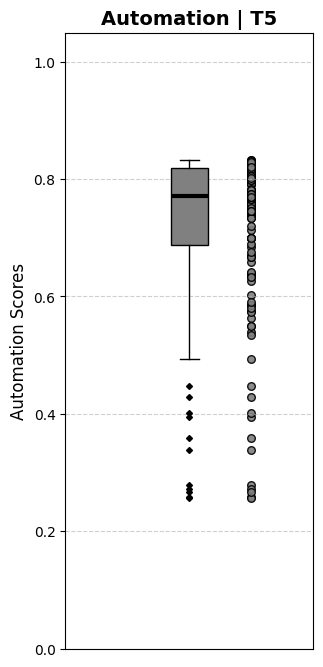

In [14]:
folder = r"automation_results_gpt2\scores"
scores = []

for filename in os.listdir(folder):
    if filename.endswith("_score.txt"):
        with open(os.path.join(folder, filename), "r") as f:
            content = f.read().strip()
            try:
                value = float(content)
                scores.append(round(value, 3))
            except ValueError:
                continue

scores = np.array(scores, dtype=float)
scores[np.isnan(scores)] = np.mean(scores[~np.isnan(scores)])

def find_outliers(data):
    data = np.array(data)
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)

    IQR = Q3 - Q1
    lower_bound = Q1 - (1.5 * IQR)
    upper_bound = Q3 + (1.5 * IQR)

    outliers = data[(data < lower_bound) | (data > upper_bound)]
    return outliers, lower_bound, upper_bound, Q1, Q3, IQR

outliers, lower_bound, upper_bound, Q1, Q3, IQR = find_outliers(scores)

def plot_scores_boxplot(scores):
    plt.figure(figsize=(3.2,8))
    plt.boxplot(
        scores,
        positions=[0.75], 
        vert=True,
        patch_artist=True,
        medianprops={'color': 'black', 'linewidth': 3},
        boxprops={'facecolor': 'gray', 'edgecolor': 'black'},
        flierprops={'marker': 'D', 'markerfacecolor': 'black', 'markersize': 3, 'linestyle': 'none'}
    )

    plt.title('Automation | T5', fontsize=14, weight='bold')
    plt.ylabel('Automation Scores', fontsize=12)
    plt.xticks([])
    plt.ylim(0, 1.05)

    #insert the text 'WIP' in center of plot
    # plt.text(0.75, 0.5, 'WIP', fontsize=12, ha='center', va='center')

    plt.grid(axis='y', linestyle='--', alpha=0.6)
    x = np.ones_like(scores)
    plt.scatter(
        x,
        scores,
        color='gray',
        edgecolor='black',
        s=30,
        alpha=0.9,
    )
    plt.show()

plot_scores_boxplot(scores)

In [364]:
# Started with 10 hand-written programs, classified all heads w/ linear interpolation, iterated over worst 20% scores one head at a time to generate multiple candidate hypotheses and choose the one with the best interpolation improvement for adding to db

model = AutoModel.from_pretrained("bert-base-uncased", output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

num_layers = model.config.num_hidden_layers
num_heads = model.config.num_attention_heads

interpolation_matrix = np.zeros((num_layers, num_heads))
patterns = [next_attention, previous_attention, same_attention, punctuation_attention, repeated_attention, pos_alignment, dependencies]

for layer in range(num_layers):
    for head in range(num_heads):

        X = []
        for pattern in patterns:
            X.append(pattern(sentence, tokenizer)[1].flatten())
        X_n = np.array(X).T

        y = model(**tokenizer(sentence, return_tensors="pt"), output_attentions=True).attentions[layer][0, head].detach().numpy().flatten()
        reg = LinearRegression().fit(X_n, y.flatten())
        out = reg.intercept_ + sum(coef * mat for coef, mat in zip(reg.coef_, X))
        len_seq = len(tokenizer([sentence], return_tensors="pt").input_ids[0])
        out = out.reshape((len_seq, len_seq))
        pred_att = out / out.sum(axis=1, keepdims=True)

        tokens = tokenizer(sentence, return_tensors="pt")
        att = model(**tokens, output_attentions=True).attentions[layer][0, head].detach().numpy()

        jensonshannon_distances = []
        for row_att, row_out in zip(att, pred_att):
            jensonshannon_distances.append(np.sqrt(js_divergence(row_att, row_out)))
        interpolation_score = np.mean(jensonshannon_distances)

        # print(type(interpolation_score), interpolation_score)

        interpolation_matrix[layer, head] = interpolation_score
        print(f"Layer {layer}, Head {head} - Interpolation Score: {interpolation_score:.4f}")

Layer 0, Head 0 - Interpolation Score: 0.1350
Layer 0, Head 1 - Interpolation Score: 0.3173
Layer 0, Head 2 - Interpolation Score: 0.3470
Layer 0, Head 3 - Interpolation Score: 0.3365
Layer 0, Head 4 - Interpolation Score: 0.2573
Layer 0, Head 5 - Interpolation Score: 0.2922
Layer 0, Head 6 - Interpolation Score: 0.2104
Layer 0, Head 7 - Interpolation Score: 0.3127
Layer 0, Head 8 - Interpolation Score: 0.2400
Layer 0, Head 9 - Interpolation Score: 0.3219
Layer 0, Head 10 - Interpolation Score: 0.2944
Layer 0, Head 11 - Interpolation Score: 0.3291
Layer 1, Head 0 - Interpolation Score: 0.3695
Layer 1, Head 1 - Interpolation Score: 0.4510
Layer 1, Head 2 - Interpolation Score: 0.5055
Layer 1, Head 3 - Interpolation Score: 0.3765
Layer 1, Head 4 - Interpolation Score: 0.3062
Layer 1, Head 5 - Interpolation Score: 0.4281
Layer 1, Head 6 - Interpolation Score: 0.6806
Layer 1, Head 7 - Interpolation Score: 0.3742
Layer 1, Head 8 - Interpolation Score: 0.3285
Layer 1, Head 9 - Interpolation 

In [407]:
# CONDUCT MODEL LEVEL ANALYSIS / GET SUMMARY SCORE FOR WHOLE MODEL

def classify_model(method, sentences, torch_model, torch_tokenizer):
    if method == "linear_fit":
        patterns = [next_attention, previous_attention, same_attention, punctuation_attention, repeated_attention, pos_alignment]
    elif method == "best_fit":
        saved_file = pd.read_csv('data/best_fit_t5.csv')
    elif method == "automation":
        from automation_helper import generate_prompt, parse_llm_idea, validate_program

    num_layers = torch_model.config.num_hidden_layers
    num_heads = torch_model.config.num_attention_heads

    all_scores = []
    final_scores = []
    
    if method != "automation":
        for idx, sentence in enumerate(sentences):
            scores = np.zeros((num_layers, num_heads))
            for i in range(num_layers):
                for j in range(num_heads):
                    layer, head = i, j
                    inputs = torch_tokenizer(sentence, return_tensors="pt")
                    len_seq = len(torch_tokenizer([sentence], return_tensors="pt").input_ids[0])

                    X = []
                    # y =  torch_model(**inputs, output_attentions=True).attentions[layer][0, head].detach().numpy()
                    decoder_input_ids = tokens["input_ids"]
                    outputs = torch_model(input_ids=inputs["input_ids"], decoder_input_ids=decoder_input_ids, output_attentions=True)
                    y = outputs.encoder_attentions[layer][0, head].detach().numpy()

                    if method == "random_baseline":
                        pred_att = np.zeros((len_seq, len_seq))
                        pred_att[:, -1] = 1.0

                    elif method == "best_fit":
                        matching_rows = saved_file[(saved_file['i'] == i) & (saved_file['j'] == j)]
                        if not matching_rows.empty:
                            best_pattern = matching_rows.loc[matching_rows['Score'].idxmax(), 'Pattern']
                            func = globals()[best_pattern]
                            _, pred_att = func(sentence, tokenizer)
                        else:
                            out = np.random.rand(len_seq, len_seq)
                            pred_att =  out / out.sum(axis=1, keepdims=True)

                    elif method == "linear_fit":
                        for pattern in patterns:
                            X.append(pattern(sentence, torch_tokenizer)[1].flatten())
                        X_n = np.array(X).T
                        y = y.flatten()

                        reg = LinearRegression().fit(X_n, y)
                        side_length = int(np.sqrt(len(y)))
                        y = y.reshape((side_length, side_length))

                        pred_att = reg.intercept_ + sum(coef * mat for coef, mat in zip(reg.coef_, X))
                        pred_att = pred_att.reshape((side_length, side_length))

                    jensonshannon_distances = []
                    for row_att, row_out in zip(y, pred_att):
                        jensonshannon_distances.append(np.sqrt(js_divergence(row_att, row_out)))
                    score = np.mean(jensonshannon_distances)
                    scores[layer, head] = score
                    
            all_scores.append(scores)
            final_scores.append(np.sum(scores))
            print(f"Processed sentence #{idx}/{len(sentences)}: Score: {np.sum(scores):.2f}\n\t->'{sentence}'")
        
    elif method == "automation":
        
        prompt = generate_prompt(sentences, model, tokenizer, (layer, head), top_k_ratio=0.025)
        hypothesis, program = parse_llm_idea(prompt, config=config, verbalize=False)
        python_path = f"{program_path}/{head}_output.py"
        feedback = validate_program(python_path, model, tokenizer, layer, head, sentences)
        scores[layer, head] = feedback
            

    print(f"Final Score: {sum(final_scores) / len(final_scores)}")
    return all_scores, final_scores

methods = ["random_baseline", "best_fit", "linear_fit"]
final_scores = {"random_baseline": 0, "best_fit": 0, "linear_fit": 0}

for method in methods:
    print(f"\nAnalyzing method: {method}")
    _, scores = classify_model(method, sentences[:10], model, tokenizer)
    final_scores[method] = np.mean(scores)

print("\n",final_scores)


Analyzing method: random_baseline
Processed sentence #0/10: Score: 24.74
	->'One day, a little girl named Lily found a needle in her room.'
Processed sentence #1/10: Score: 24.47
	->'She knew it was difficult to play with it because it was sharp.'
Processed sentence #2/10: Score: 25.61
	->'Lily wanted to share the needle with her mom, so she could sew a button on her shirt.'
Processed sentence #3/10: Score: 24.91
	->'Lily went to her mom and said, "Mom, I found this needle.'
Processed sentence #4/10: Score: 24.97
	->'Can you share it with me and sew my shirt?"'
Processed sentence #5/10: Score: 26.58
	->'Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt."'
Processed sentence #6/10: Score: 24.51
	->'Together, they shared the needle and sewed the button on Lily's shirt.'
Processed sentence #7/10: Score: 25.64
	->'It was not difficult for them because they were sharing and helping each other.'
Processed sentence #8/10: Score: 25.48
	->'After they finished, Li

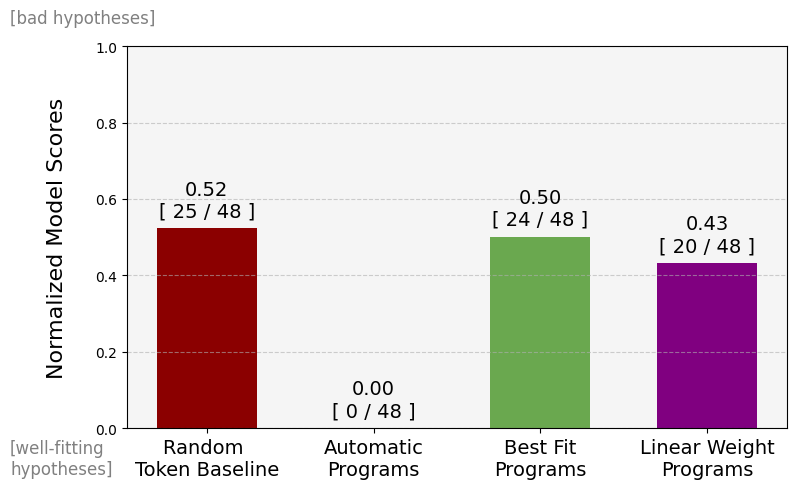

In [408]:
# PLOT DIFFERENT SUMMARY SCORES FOR THE MODEL

max_score = model.config.num_hidden_layers * model.config.num_attention_heads
raw_scores = [25.11, 0, 24.06, 20.78]
labels = ['Random \nToken Baseline', 'Automatic\nPrograms', 'Best Fit\nPrograms', 'Linear Weight\nPrograms']
colors = ['darkred', 'darkblue', '#6aa84f', '#800080']

# Normalize scores: lower scores become higher bars
scores = [(score / max_score) for score in raw_scores]
fig, ax = plt.subplots(figsize=(8, 5))
bars = plt.bar(labels, scores, color=colors, width=0.6)

# Add text labels on top of bars
for bar, raw, norm in zip(bars, raw_scores, scores):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.02,
             f'{norm:.2f}\n[ {int(raw)} / {max_score} ]', ha='center', va='bottom', fontsize=14)
ax.set_facecolor('#F5F5F5')

plt.ylim(0, 1.0)
# plt.title('Normalized Error (1 - Score / Max Score)')
plt.xticks(fontsize=14)
plt.text(plt.xlim()[0]-0.7, plt.ylim()[1]+0.05, '[bad hypotheses]', ha='left', va='bottom', fontsize=12, color='gray')
plt.text(plt.xlim()[0]-0.7, plt.ylim()[0]-0.13, '[well-fitting\nhypotheses]', ha='left', va='bottom', fontsize=12, color='gray')
plt.ylabel('Normalized Model Scores', fontsize=16, labelpad=20)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

<div style="text-align: center; font-size: 2em;">
  <hr>
    Program Automation Efforts
  <hr>
</div>

In [ ]:
# AUTOMATICALLY GENERATE PATTERNS FOR A HEAD & GENERATE LLM PROMPT

example_program_one = """
def dependencies(sentence: str, tokenizer: PreTrainedTokenizerBase) -> Tuple[str, np.ndarray]: /
    toks = tokenizer([sentence], return_tensors="pt") /
    len_seq = len(toks.input_ids[0]) /
    out = np.zeros((len_seq, len_seq)) /
    words = sentence.split() /
    doc = nlp(" ".join(words)) /
    for stok in doc: /
        parent_index = stok.i /
        for child_stok in stok.children: /
            child_index = child_stok.i /
            out[parent_index+1, child_index+1] = 1 /
            out[child_index+1, parent_index+1] = 1 /
    out[0, 0] = 1 /
    out[-1, 0] = 1 /
    out += 1e-4 /
    out = out / out.sum(axis=1, keepdims=True) /
    return "Dependency Parsing Pattern", out /
"""
example_program_two = """
def same_attention(sentence: str, tokenizer: PreTrainedTokenizerBase) -> Tuple[str, np.ndarray]: /
    toks = tokenizer([sentence], return_tensors="pt")
    len_seq = len(toks.input_ids[0])
    out = np.zeros((len_seq, len_seq))
    for i in range(1, len_seq-1):
        out[i, i] = 1
    out[0,0] = 1
    out[-1,0] = 1
    return "Same Token Pattern", out
"""
example_program_three = """
def pos_alignment(sentence: str, tokenizer: PreTrainedTokenizerBase) -> Tuple[str, np.ndarray]:
    toks = tokenizer([sentence], return_tensors="pt") /
    len_seq = len(toks.input_ids[0]) /
    out = np.zeros((len_seq, len_seq)) /
    # assign toks, input_ids, word_ids, len_seq, out, doc /
    # use spacey to get pos_tags for tokens in docs [token.pos_ for token in doc] /
    # for token in pos_tags: /
    # loop through pos_tags and increment out[i,j] when pos_tags match /
    # assign cls (out[0, 0] = 1) and eos (out[-1, 0] = 1) to have self_attention /
    # Normalize out matrix by row (results in uniform attention) and return out /
    # return 'Part of Speech Implementation 1', out /
"""

def generate_prompt(sentences, model, tokenizer, head_loc, top_k_ratio=0.1):
    layer, head = head_loc
    data = {
        "layer": layer,
        "head": head,
        "model": model.config.architectures[0],
        "examples": []
    }

    def handle_score(score):
        # convert to percentage with 0 decimal places
        return "{:.0f}".format(score * 100)
        
    def scrape_head(att, tokens, top_k_ratio, ignore_special=True):
        seq_len = att.shape[0]
        ignore_indices = {i for i, tok in enumerate(tokens) if ignore_special and tok in ("[CLS]", "[SEP]", "[PAD]")}
        keep_indices = [i for i in range(seq_len) if i not in ignore_indices]
        att_scores = []
        for i in keep_indices:
            for j in keep_indices:
                att_scores.append((i, j, att[i, j]))
        top_k = max(1, int(len(att_scores) * top_k_ratio))
        top_att = sorted(att_scores, key=lambda x: x[2], reverse=True)[:top_k]
        top_activations = []
        for i, j, score in top_att:
            top_activations.append(f"[{str(tokens[i])}|{str(tokens[j])}:{handle_score(score)}]")
        top_activations_str = " ".join(top_activations).replace("[", "").replace("]", "")
        return top_activations_str
    
    for idx, sentence in enumerate(sentences):
        inputs = tokenizer(sentence, return_tensors="pt")
        tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
        with torch.no_grad():
            outputs = model(**inputs, output_attentions=True)
            att = outputs.attentions[layer][0, head]
        att = att.detach().cpu().numpy()
        top_activations = scrape_head(att, tokens, top_k_ratio=top_k_ratio)
        item = {f"sentence {idx}": " ".join(tokens), "sentence attention": top_activations}
        data["examples"].append(item)

    data = json.dumps(data, indent=2)
    prompt = f"""
    Using the following pieces of data based on {len(sentences)} sentences, generate three hypothesises about the linguistic role the following head is responsible for based on patterns
    in the activations.  Then, choose the most fitting hypothesis for the head function using examples from the data. Finally, using the linguistic hypothesis you determine, 
    write a python function which takes in a sentence and tokenizer as parameters and outputs the name of the pattern you hypothesize along with a predicted_matrix (size: token_len * token_len), which is the 
    rule encoded matrix mirroring attention patterns you'd predict for any given sentence for Layer {layer}, Head {head}. Feel free to encode complex functions but write the simplest algorithm that captures your 
    observed pattern. You must respond to this prompt in JSON in the form "{{"hypothesis": "...", "program": "..."}} with your chosen hypothesis. Think carefully before generating any code.
    The first portion of your response has key "hypothesis" with the title of the hypothesis and the second portion of your response with key "program" should have valid python code starting with ```python and including imports. These patterns can be simple or 
    complex.  For uniformity, the first three lines of your function should be 'toks = tokenizer([sentence], return_tensors="pt") len_seq = len(toks.input_ids[0]) out = np.zeros((len_seq, len_seq))'.
    Make sure the token sequences from your tokenizer and spaCy (if you must use spaCy) are aligned via a dictionary if necessary, because they split text differently. Make sure you generalize your hypothesis pattern to any sentence. Functions can almost 
    always be expressed in fewer than 50 lines of code. As examples, it has been discovered one head is responsible for the complex task of dependency parsing. It's simplistic predicted pseudocode looks like: 
    {example_program_one}. Example 2: '''{example_program_two}''' Example 3: '''{example_program_three}'''. DATA: {data}"""
    return ' '.join(prompt.strip().split())

model_name = "bert-base-uncased"
model = AutoModel.from_pretrained(model_name, output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained(model_name)

layer, head = 5, 7
prompt = generate_prompt(generic_sentences[:25], model, tokenizer, (layer, head), 0.025)
print(prompt)

In [ ]:
# Using Gemini, GPT-4o, Claude, Deepseek
# API needs long contexts and free access
# Source to get API keys is "usage" key

load_dotenv()
API_CONFIGS = {
    "gemini": {
        "model": "gemini",
        "url": "https://generativelanguage.googleapis.com/v1beta/models/gemini-2.0-flash:generateContent",
        "key": os.getenv("GEMINI"),
        "headers_fn": lambda key: {"Content-Type": "application/json", "X-goog-api-key": key},
        "payload_fn": lambda prompt: {
            "contents": [{"parts": [{"text": prompt}]}],
            "generationConfig": {"response_mime_type": "application/json"}
        },
        "usage": "https://aistudio.google.com/apikey"
    },
    "openai": {
        "model": "openai",
        "url": "https://api.openai.com/v1/responses",
        "key": os.getenv("OPENAI"),
        "headers_fn": lambda key: {"Authorization": f"Bearer {key}", "Content-Type": "application/json"},
        "payload_fn": lambda prompt: {"model": "gpt-4.1", "input": prompt},
        "usage": "https://platform.openai.com/account/api-keys"
    },
    "claude": {
        "model": "claude",
        "url": "https://api.anthropic.com/v1/messages",
        "key": os.getenv("CLAUDE"),
        "headers_fn": lambda key: {"x-api-key": key, "Content-Type": "application/json", "Anthropic-Version":"2023-06-01"},
        "payload_fn": lambda prompt: {"model":"claude-sonnet-4-20250514", "messages":[{"role":"user","content":prompt}]},
        "usage": "https://platform.claude.com/api_keys"
    },
    "deepseek": {
        "model": "deepseek",
        "url": "https://api.deepseek.com/chat/completions",
        "key": os.getenv("DEEPSEEK"),
        "headers_fn": lambda key: {"Authorization": f"Bearer {key}", "Content-Type": "application/json"},
        "payload_fn": lambda prompt: {"model": "deepseek-chat", "input": prompt, "max_tokens": 1000},
        "usage": "https://platform.deepseek.com/api_keys"
    }
}

In [ ]:
# SAVE AUTOMATED HYPOTHESIS + VALIDATE GENERATED PROGRAM SYNTHESIS CODE

def parse_llm_idea(prompt, config="YOUR_API_CONFIG", verbalize=True):
    def make_request():
        headers = config["headers_fn"](config["key"])
        payload = config["payload_fn"](prompt)
        response = requests.post(config["url"], headers=headers, data=json.dumps(payload))
        response.raise_for_status()

        if config["model"] == "gemini":
            data = response.json()
            output = data["candidates"][0]["content"]["parts"][0]["text"]
        if config["model"] == "openai":
            pass
        if config["model"] == "claude":
            data = response.json()
            output = data["content"]["text"]
        if config["model"] == "deepseek":
            pass

        return output
    
    output = make_request()

    try:
        result = json.loads(output)

        if type(result) is list: result = result[0]
        hypothesis = result.get("hypothesis", "")
        program = result.get("program", "")

        if program.startswith("```python"): program = program[9:]
        if program.endswith("```"): program = program[:-3]
        program = program.strip()

        if verbalize: print("Hypothesis, Explanation & Program successfully parsed")

    except Exception as e:
        print(f"Parsing API failed: {str(e)}")
        return str(e)

    return hypothesis, program

config = API_CONFIGS["gemini"] 
parse_llm_idea(prompt, config=config, verbalize=True)

In [ ]:
# SIMPLE AUTOMATION OF PIPELINE FOR ANALYZING ALL HEADS & WRITING/SAVING PROGRAMS

def automation_pipeline(model, tokenizer, sentences, API_KEY, save_data=True, evaluate=False):
    heads = model.config.num_attention_heads
    layers = model.config.num_hidden_layers
    prompts, programs = [], []

    for layer in range(layers):
        # if layer == 0: continue
        if save_data:
            # save prompts:
            prompt_path = f"automation_2/prompts/{layer}/"
            os.makedirs(prompt_path, exist_ok=True)

            # save programs:
            program_path = f"automation_2/llm_code/code_layer_{layer}/"
            os.makedirs(program_path, exist_ok=True)

            # save scores:
            if evaluate:
                score_path = f"automation_2/scores/{layer}/"
                os.makedirs(score_path, exist_ok=True)

        for head in range(heads):
            # if head < 9: continue
            if (layer, head) not in failed_programs:
                continue
            prompt = generate_prompt(sentences, model, tokenizer, (layer, head), top_k_ratio=0.1)
            hypothesis, explanation, program = parse_llm_idea(prompt, API_KEY, output=False)
            print(f"Analyzed Layer {layer}, Head {head} | Hypothesis ~ {hypothesis} ")

            prompts.append(prompt)
            programs.append(program)

            if save_data:
                with open(f"{prompt_path}/{layer}_{head}_prompt.txt", "w") as f: f.write(prompt)
                with open(f"{program_path}/{head}_output.py", "w") as f: f.write(program)

        if evaluate: 
            pass

    return None

automation_pipeline(model, tokenizer, generic_sentences[:10], API_KEY=API_KEY, save_data=True, evaluate=False)

In [ ]:
import importlib.util
import types

def validate_program(program_path, model, tokenizer, layer, head, sentences):       
    try:
        spec = importlib.util.spec_from_file_location("loaded_program", program_path)
        module = importlib.util.module_from_spec(spec)
        module.__dict__['np'] = np
        spec.loader.exec_module(module)
    except Exception as e:
        print(f"Program loading failed: {str(e)}")
        return str(e)

    for attr_name in dir(module):
        attr = getattr(module, attr_name)
        if isinstance(attr, types.FunctionType):
            program = attr
            break

    # try:
    score = score_prediction(model, tokenizer, (layer, head), program, sentences, distance="jsd", output=True)
    return score
    # except Exception as e:
    #     print(f"Program validation failed: {str(e)}")
    #     return str(e)

python_path = r"automation_results_gemini\llm_code\programs-layer_0\0_output.py"
feedback = validate_program(python_path, model, tokenizer, layer, head, sentences)

In [ ]:
# CALCULATE AND SAVE SCORES FOR AUTOMATICALLY GENERATED PROGRAMS

import importlib.util
import types

scores = []
failed_programs = []
for layer in range(12):
    # if layer != 11: continue
    code_path = f"automation_2/llm_code/code_layer_{layer}/"
    for j in range(12):
        # if j != 11: continue
        filename = f"{j}_output.py"
        program_path = os.path.join(code_path, filename)
        if not os.path.exists(program_path): continue
        score_path = f"automation_2/scores/{layer}_{j}_score.txt"
        os.makedirs(os.path.dirname(score_path), exist_ok=True)

        try:
            spec = importlib.util.spec_from_file_location(f"layer{layer}_j{j}", program_path)
            module = importlib.util.module_from_spec(spec)
            module.__dict__['np'] = np
            spec.loader.exec_module(module)
        except Exception as e:
            print(f"Layer {layer}, Head {j} - Error: {e}")
            with open(score_path, "w") as f: f.write(f"Error loading module: {e}")
            failed_programs.append((layer, j))
            scores.append(-1)
            continue

        for attr_name in dir(module):
            attr = getattr(module, attr_name)
            if isinstance(attr, types.FunctionType):
                program_to_test = attr
                break

        try:
            score = score_prediction(model, tokenizer, (layer, j), program_to_test, generic_sentences[0], distance="jsd", output=False)
            print(f"Layer {layer}, Head {j} - Score: {score:.2f}")
            with open(score_path, "w") as f: f.write(f"{score:.2f}")
            scores.append(score)
        except Exception as e:
            print(f"Layer {layer}, Head {j} - Error: {e}")
            with open(score_path, "w") as f: f.write(f"Error during scoring: {e}")
            failed_programs.append((layer, j))
            scores.append(-1)
            continue

num_scored = len([s for s in scores if s != -1 and not np.isnan(s)])
print(f"Number of Successfully Scored Heads: {num_scored} out of {len(scores)}")

avg_score = sum([s for s in scores if s != -1 and not np.isnan(s)]) / len([s for s in scores if s != -1 and not np.isnan(s)])
print(f"Average Score (excluding errors): {avg_score:.2f}")

In [305]:
# make scores into a matrix (12,12) with -1 for failed programs

sq_score = np.full((12, 12), -1.0)
for idx, score in enumerate(scores):
    layer = idx // 12
    head = idx % 12
    sq_score[layer, head] = score

sq_score

array([[0.139, 0.628, 0.736, 0.782, 0.792, 0.813, 0.737, 0.754, 0.696,
        0.711, 0.735, 0.702],
       [0.557, 0.62 , 0.759, 0.782, 0.697, 0.643, 0.777, 0.741, 0.733,
        0.734, 0.701, 0.721],
       [0.682, 1.   , 0.649, 0.635, 0.642, 0.648, 0.713, 0.464, 0.577,
        0.68 , 0.782, 0.617],
       [0.643, 0.799, 0.738, 0.768, 0.707, 0.722, 0.819, 0.572, 0.807,
        0.723, 0.685, 0.663],
       [0.725, 0.753, 0.753, 0.763, 0.713, 0.446, 0.654, 0.707, 0.692,
        0.665, 0.674, 0.745],
       [0.678, 0.709, 0.672, 0.622, 0.63 , 0.756, 0.542, 0.628, 0.637,
        0.708, 0.373, 0.738],
       [0.404, 0.533, 1.   , 0.624, 0.37 , 0.537, 0.514, 0.531, 0.754,
        0.76 , 0.582, 0.698],
       [0.38 , 0.469, 0.606, 0.28 , 0.491, 0.541, 0.516, 0.698, 0.199,
        0.805, 0.439, 0.535],
       [0.635, 0.284, 0.581, 0.415, 0.444, 0.205, 0.306, 0.4  , 0.805,
        0.681, 0.497, 0.538],
       [0.616, 0.717, 0.318, 0.55 , 0.416, 0.647, 0.465, 0.552, 0.645,
        0.748, 0.66 

In [381]:
sq_score[2,1] = 0.8
sq_score[6,2] = 0.75

sq_score = interpolation_matrix

In [18]:
scores

array([0.659, 0.822, 0.667, 0.671, 0.821, 0.751, 0.753, 0.762, 0.7  ,
       0.768, 0.81 , 0.684, 0.636, 0.832, 0.776, 0.829, 0.259, 0.64 ,
       0.809, 0.667, 0.279, 0.768, 0.824, 0.822, 0.493, 0.55 , 0.779,
       0.802, 0.805, 0.825, 0.766, 0.633, 0.812, 0.763, 0.54 , 0.782,
       0.822, 0.762, 0.576, 0.814, 0.814, 0.819, 0.825, 0.822, 0.448,
       0.825, 0.812, 0.823, 0.563, 0.82 , 0.585, 0.257, 0.626, 0.738,
       0.55 , 0.573, 0.807, 0.585, 0.766, 0.641, 0.814, 0.822, 0.713,
       0.603, 0.826, 0.822, 0.823, 0.828, 0.828, 0.791, 0.771, 0.791,
       0.766, 0.829, 0.833, 0.825, 0.752, 0.796, 0.338, 0.801, 0.818,
       0.739, 0.819, 0.721, 0.804, 0.827, 0.676, 0.759, 0.791, 0.739,
       0.823, 0.826, 0.758, 0.775, 0.358, 0.751, 0.394, 0.828, 0.767,
       0.743, 0.743, 0.828, 0.401, 0.784, 0.825, 0.534, 0.734, 0.699,
       0.581, 0.699, 0.83 , 0.766, 0.825, 0.428, 0.591, 0.733, 0.81 ,
       0.801, 0.772, 0.827, 0.769, 0.769, 0.746, 0.831, 0.272, 0.266,
       0.782, 0.775,

In [20]:
#make scores sqauare and assign to sq_score
sq_score = np.reshape(scores, (12, 12))

In [15]:
sq_score = scores

C:\Users\amkah\AppData\Local\Temp\ipykernel_32040\4273937716.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(colors).copy()


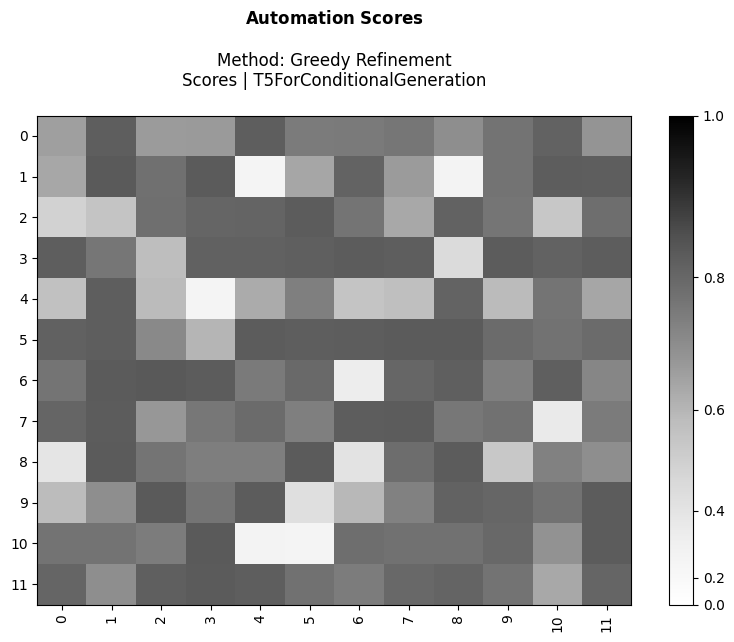

In [105]:
colors = "Grays"
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
masked_sq = np.ma.masked_where(sq_score == -1, sq_score)
norm = PowerNorm(gamma=1.8, vmin=sq_score.min(), vmax=sq_score.max())
cmap = plt.cm.get_cmap(colors).copy()
cmap.set_bad(color='gray')
im2 = ax.imshow(masked_sq, cmap=cmap, aspect='auto', norm=norm)
im2.set_clim(vmin=0, vmax=1)
cbar = plt.colorbar(im2, ax=ax)
ax.set_xticks(range(12))
ax.set_yticks(range(12))
ax.set_xticklabels([i for i in range(12)], rotation=90)
ax.set_yticklabels([i for i in range(12)])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# put a space element in between automation and scores in text
title = (
    r'$\mathbf{Automation \ Scores}$'  # \mathbf makes the text bold
    '\n\nMethod: Greedy Refinement'
    f'\nScores | {model.config.architectures[0]}'  # Example: replaced model.config...
)
plt.title(f"{title}\n")
plt.show()

C:\Users\amkah\AppData\Local\Temp\ipykernel_32040\4221750954.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(colors).copy()


usetex: False


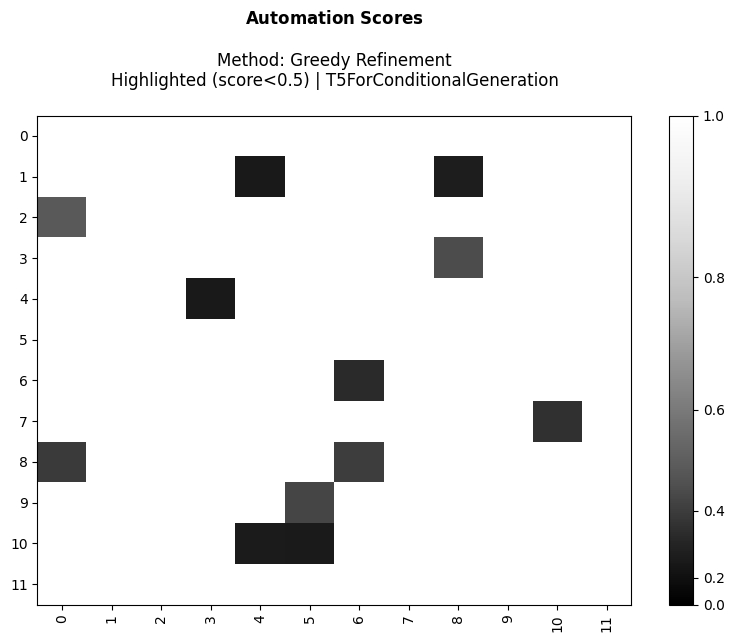

In [ ]:
import matplotlib.pyplot as plt
colors = "Grays_r"
plt.rcParams['text.usetex'] = False

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
highlighted_sq = np.where(sq_score < 0.5, sq_score, np.nan)
# make all non-highlighted values white (1.0)
highlighted_sq = np.where(np.isnan(highlighted_sq), 1.0, highlighted_sq)
norm = PowerNorm(gamma=1.8, vmin=sq_score.min(), vmax=sq_score.max())
cmap = plt.cm.get_cmap(colors).copy()
cmap.set_bad(color='gray')
im2 = ax.imshow(highlighted_sq, cmap=cmap, aspect='auto', norm=norm)
im2.set_clim(vmin=0, vmax=1)
cbar = plt.colorbar(im2, ax=ax)
ax.set_xticks(range(12))
ax.set_yticks(range(12))
ax.set_xticklabels([i for i in range(12)], rotation=90)
ax.set_yticklabels([i for i in range(12)])
import matplotlib
print("usetex:", matplotlib.rcParams['text.usetex'])
plt.rcParams['text.usetex'] = False

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# make automation bold
title = (
    r'$\mathbf{Highlighted\ Scores}$'
    '\n\nMethod: Greedy Refinement'
    f'\n Score < 0.5 | {model.config.architectures[0]}\n')
# title = "Automation Scores\n"
plt.title(title)
plt.show()

In [79]:
colors = "Grays_r"
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
highlighted_sq = np.where(sq_score < 0.5, sq_score, np.nan)
# make all non-highlighted values white (1.0)
highlighted_sq = np.where(np.isnan(highlighted_sq), 1.0, highlighted_sq)
norm = PowerNorm(gamma=1.8, vmin=sq_score.min(), vmax=sq_score.max())
cmap = plt.cm.get_cmap(colors).copy()
cmap.set_bad(color='gray')
im2 = ax.imshow(highlighted_sq, cmap=cmap, aspect='auto', norm=norm)
im2.set_clim(vmin=0, vmax=1)
cbar = plt.colorbar(im2, ax=ax)
ax.set_xticks(range(12))
ax.set_yticks(range(12))
ax.set_xticklabels([i for i in range(12)], rotation=90)
ax.set_yticklabels([i for i in range(12)])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# put a space element in between automation and scores in text
# title = (
#     'Automation Scores'  # \mathbf makes the text bold
#     '\n\nMethod: Greedy Refinement'
#     f'\nHighlighted (score<0.5) | {model.config.architectures[0]}'  # Example: replaced model.config...
# )
title = "Automation Scores\n"
plt.title(title)
plt.show()

C:\Users\amkah\AppData\Local\Temp\ipykernel_32040\332804323.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(colors).copy()


RuntimeError: Failed to process string with tex because latex could not be found

<div style="text-align: center; font-size: 2em;">
  <hr>
    Hypothesis Structure Experiments
  <hr>
</div>

In [ ]:
import networkx as nx
from programs import *

programs = [next_attention, previous_attention, same_attention, punctuation_attention, dependencies,
            last_token_attention, uniform_attention, cls_attention, eos_attention, pos_alignment,
            special_token_attention, repeated_attention, noun_modifier_attention, pronoun_attention,
            single_token_attention, root_cluster_attention]

sentence_data = sentences[:25]
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def program_similarity(att_one, att_two):
    def js_divergence(p: np.ndarray, q: np.ndarray) -> float:
        p = np.clip(p, 1e-12, 1.0)
        q = np.clip(q, 1e-12, 1.0)
        p /= p.sum()
        q /= q.sum()
        m = 0.5 * (p + q)
        return 0.5 * (np.sum(p * np.log(p / m)) + np.sum(q * np.log(q / m))) 

    jensonshannon_distances = []
    for row_att, row_out in zip(att_one, att_two):
        jensonshannon_distances.append(np.sqrt(js_divergence(row_att, row_out)))
    score = np.mean(jensonshannon_distances)
    return score

x = len(programs)
S = np.zeros((x, x))
for i in range(x):
    print(f"calculating hypothesis similarities [{i}]: {programs[i].__name__}")
    for j in range(x):
        if i != j:
            similarities = []
            program_one = programs[i]
            program_two = programs[j]

            for sentence in sentence_data:
                h1, activations_one = program_one(sentence, tokenizer)
                h2, activations_two = program_two(sentence, tokenizer)
                similarities.append(program_similarity(activations_one, activations_two))
            
            S[i, j] = np.mean(similarities)

In [ ]:
S

In [ ]:
def group_similar_programs(programs, S, threshold=0.6):
    groups, used = [], set()
    for i in range(len(programs)):
        if i in used: continue
        group = [i]
        used.add(i)
        
        changed = True
        while changed:
            changed = False
            for group_member in group:
                for j in range(len(programs)):
                    if j not in used and S[group_member, j] < threshold:
                        group.append(j)
                        used.add(j)
                        changed = True
        groups.append([programs[idx].__name__ for idx in group])
    
    return groups

groups = group_similar_programs(programs, S, threshold=0.6)
for i, group in enumerate(groups):
    print(f"Group {i+1}: {group}")

In [ ]:
name_to_idx = {fn.__name__: i for i, fn in enumerate(programs)}
new_order = [name_to_idx[name] for group in groups for name in group]
S_grouped = S[np.ix_(new_order, new_order)]
colors = "Purples_r"
fig, ax = plt.subplots(1, 1, figsize=(8,8))
im2 = ax.imshow(S_grouped, cmap=colors, aspect='auto')
# ax.set_axis_off()
ax.set_xticks(range(len(programs)))
ax.set_yticks(range(len(programs)))
ax.set_xticklabels([p.__name__ for p in programs], rotation=90)
ax.set_yticklabels([p.__name__ for p in programs])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.title("Similarity Matrix\n", weight='bold')
plt.show()